In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageOps
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader

In [87]:
class PadToSize:
    def __init__(self, target_width, target_height):
        self.target_width = target_width
        self.target_height = target_height

    def __call__(self, img):
        # Get the current dimensions of the image
        width, height = img.size

        # Calculate padding on each side to center the image
        pad_width = max(0, (self.target_width - width) // 2)
        pad_height = max(0, (self.target_height - height) // 2)

        # Apply padding
        padding = (pad_width, pad_height, self.target_width - width - pad_width, self.target_height - height - pad_height)
        return ImageOps.expand(img, padding, fill=0) # Black padding

In [88]:
class LoadTifDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = str(self.labels_df.iloc[idx, 0]).zfill(3)  # Zero-pad to 3 digits
        label = self.labels_df.iloc[idx, 1]  # Get the label (0 or 1)
        
        # Full path to the .tif image
        img_path = os.path.join(self.image_dir, f"{img_name}.tif")
        
        # Open the image and convert to grayscale mode "L"
        image = Image.open(img_path)     #.convert('L')  # Ensures image is 8-bit grayscale
        
        # If image is 16-bit, convert it to 8-bit grayscale
        if image.mode == 'I;16B':
            # Convert 16-bit to 8-bit by scaling down
            image = (np.array(image) / 256).astype(np.uint8)  # Scale pixel values to 8-bit
            image = Image.fromarray(image)  # Convert back to PIL Image
            image = image.convert('L')  # Ensure it's in 8-bit grayscale

        # Ensure all images are in 8-bit grayscale mode
        # else:
        #     image = image.convert('L')

        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

In [97]:
target_size = (1500, 1470) 
final_resize_size = (224, 224)  

# train_transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
#     transforms.Resize((224, 224)),  # Resize to the size expected by the pre-trained model
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ImageNet
# ])


train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    #PadToSize(*target_size),  # Pad to the target size of the largest image
    transforms.Resize(final_resize_size),  # Resize the shorter side first
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    #PadToSize(*target_size),  # Pad to the target size of the largest image
    transforms.Resize(final_resize_size),  # Resize the shorter side first
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ImageNet
])


In [98]:
# Paths to the CSV file and image directory
csv_file = '../data/training.csv'
image_dir = '../data/training/'

csv_file_val = '../data/validation.csv'
image_dir_val = '../data/validation/'

# Create datasets
train_dataset = LoadTifDataset(csv_file=csv_file, image_dir=image_dir, transform=val_transform)
val_dataset = LoadTifDataset(csv_file=csv_file_val, image_dir=image_dir_val, transform=val_transform)

# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [99]:
def unnormalize_image(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return tensor

def plot_train_vs_validation(train_dataloader, val_dataloader, label=1, n_samples=5):
    # Filter out the images with label=1 from both datasets
    train_images = [(img, lbl) for img, lbl in train_dataloader.dataset if lbl == label]
    val_images = [(img, lbl) for img, lbl in val_dataloader.dataset if lbl == label]

    # Randomly select n_samples from each set
    random_train = random.sample(train_images, n_samples)
    random_val = random.sample(val_images, n_samples)
    
    # Define mean and std for unnormalizing (same as used in normalization)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Plot the images side by side
    plt.figure(figsize=(12, 6))
    for i, ((train_img, _), (val_img, _)) in enumerate(zip(random_train, random_val)):
        
        # Unnormalize the images before plotting
        train_img = unnormalize_image(train_img, mean, std)
        val_img = unnormalize_image(val_img, mean, std)
        
        # Squeeze the channel dimension (from [1, H, W] to [H, W]) for grayscale images
        #train_img = train_img.squeeze(0)
        #val_img = val_img.squeeze(0)
        train_img = train_img.permute(1, 2, 0) 
        val_img = val_img.permute(1, 2, 0) 

       # Train images
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(train_img.numpy())  # Plot in [0, 1] range now
        plt.title("Train Image")
        plt.axis('off')
        
        # Validation images
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(val_img.numpy())  # Plot in [0, 1] range now
        plt.title("Validation Image")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

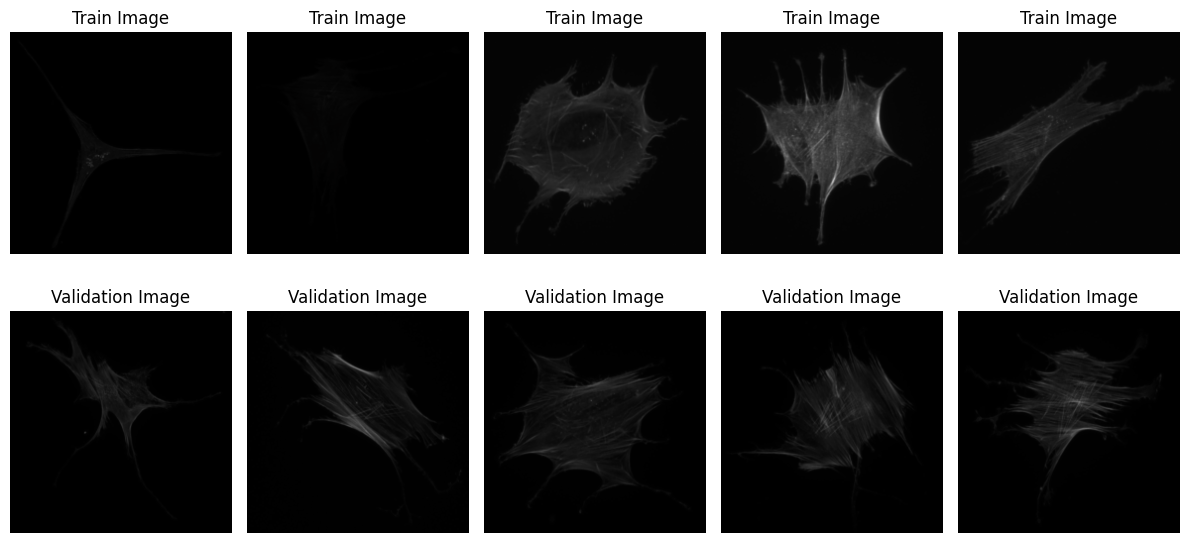

In [102]:
plot_train_vs_validation(train_dataloader, val_dataloader, label=0, n_samples=5)

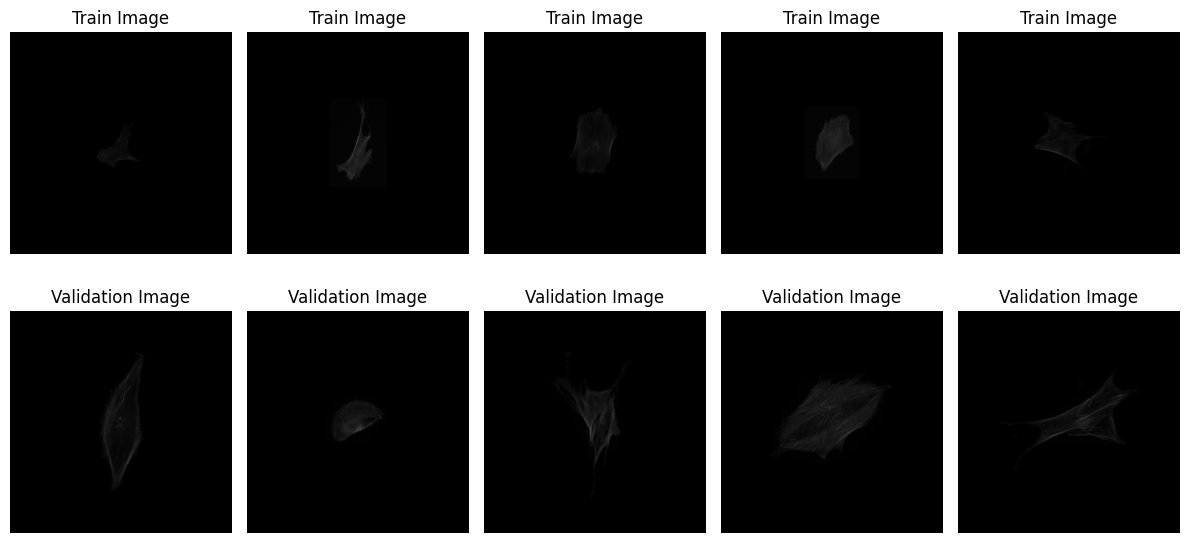

In [96]:
# Call this function with your train and validation dataloaders
plot_train_vs_validation(train_dataloader, val_dataloader, label=1, n_samples=5)

In [62]:
# Load the CSV file with image indices and labels
csv_file_path = '../data/training.csv'
image_dir = '../data/training/'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Separate the data by labels
label_0 = df[df['is_homogenous'] == 0]
label_1 = df[df['is_homogenous'] == 1]

# Randomly select 5 samples from each label
random_label_0 = label_0.sample(n=5, random_state=42)
random_label_1 = label_1.sample(n=5, random_state=42)

# Concatenate the two sets of random samples
random_samples = pd.concat([random_label_0, random_label_1])

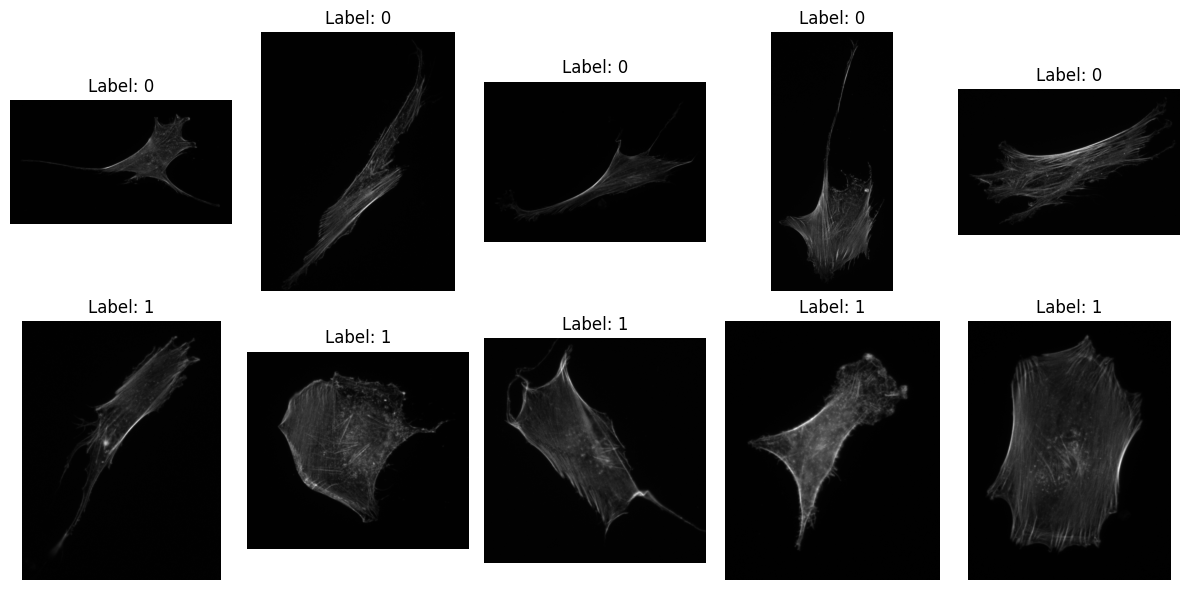

In [63]:
# Function to load and plot images
def plot_images(image_indices, labels, image_dir):
    plt.figure(figsize=(12, 6))
    
    for i, (index, label) in enumerate(zip(image_indices, labels)):
        img_path = os.path.join(image_dir, f"{str(index).zfill(3)}.tif")
        
        # Load the image
        img = Image.open(img_path)
        
        # Plot the image
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')  # Turn off the axis for a cleaner look

    plt.tight_layout()
    plt.show()

# Get the indices and labels for the selected samples
image_indices = random_samples['image_id '].values
labels = random_samples['is_homogenous'].values

# Plot the images
plot_images(image_indices, labels, image_dir)

In [13]:
# Load the CSV file with image indices and labels
csv_file_path = '../data/validation.csv'
image_dir = '../data/validation/'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Separate the data by labels
label_0 = df[df['is_homogenous'] == 0]
label_1 = df[df['is_homogenous'] == 1]

# Randomly select 5 samples from each label
random_label_0 = label_0.sample(n=5, random_state=42)
random_label_1 = label_1.sample(n=5, random_state=42)

# Concatenate the two sets of random samples
random_samples = pd.concat([random_label_0, random_label_1])

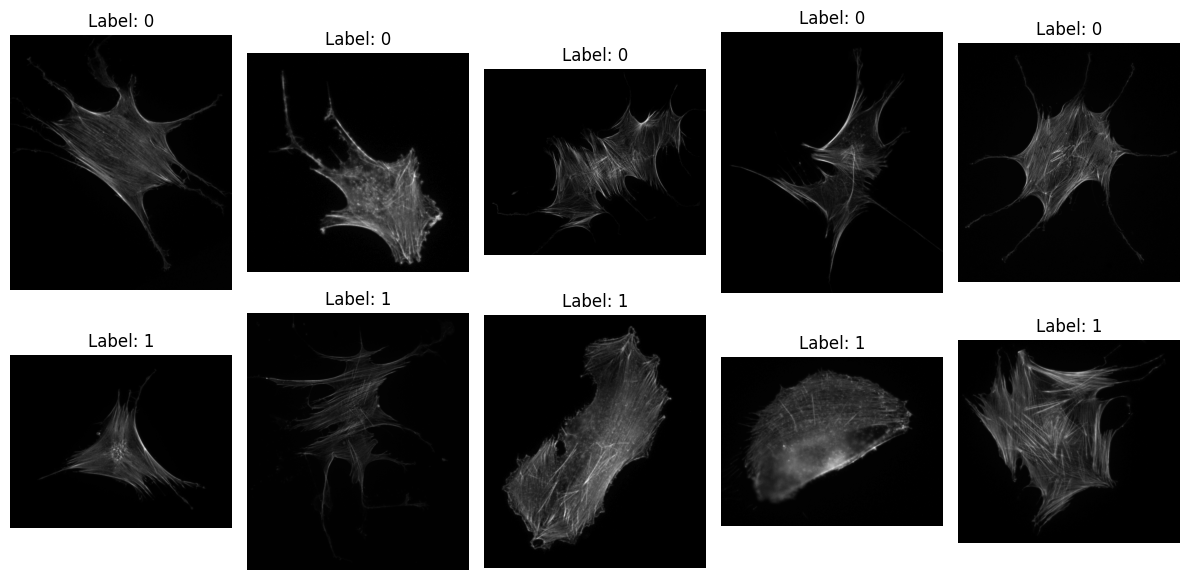

In [14]:
# Get the indices and labels for the selected samples
image_indices = random_samples['image_id '].values
labels = random_samples['is_homogenous'].values

# Plot the images
plot_images(image_indices, labels, image_dir)

In [75]:
def plot_train_vs_validation(train_dataloader, val_dataloader, label=1, n_samples=5):
    # Filter out the images with label=1 from both datasets
    train_images = [(img, lbl) for img, lbl in train_dataloader.dataset if lbl == label]
    val_images = [(img, lbl) for img, lbl in val_dataloader.dataset if lbl == label]

    # Randomly select n_samples from each set
    random_train = random.sample(train_images, n_samples)
    random_val = random.sample(val_images, n_samples)

    # Plot the images side by side
    plt.figure(figsize=(12, 6))
    for i, ((train_img, _), (val_img, _)) in enumerate(zip(random_train, random_val)):
        # Squeeze the channel dimension (from [1, H, W] to [H, W]) for grayscale images
        train_img = train_img.squeeze(0)
        val_img = val_img.squeeze(0)

        # Train images
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(train_img, cmap='gray')  # Use gray colormap
        plt.title("Train Image")
        plt.axis('off')
        
        # Validation images
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(val_img, cmap='gray')  # Use gray colormap
        plt.title("Validation Image")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


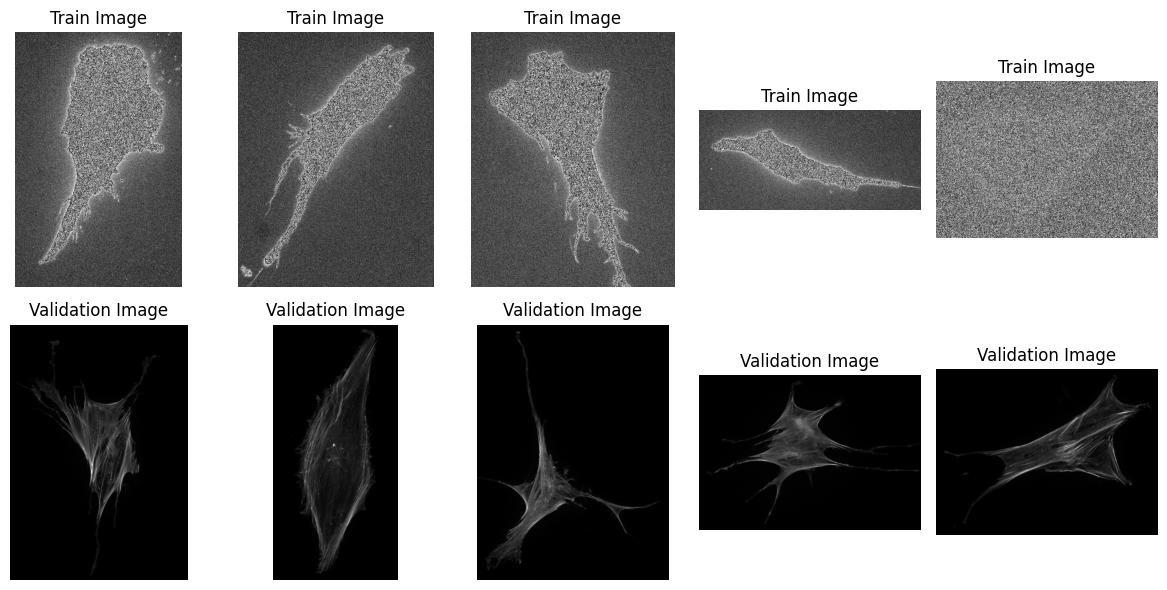

In [76]:
# Call this function with your train and validation dataloaders
plot_train_vs_validation(train_dataloader, val_dataloader, label=1, n_samples=5)

# Extend data with data argumentation on training data

In [103]:
import os
from PIL import Image
import torchvision.transforms as transforms

In [107]:
# Set up directories
input_dir = '../data/training/'  # Path to your original images
output_dir = 'data_augmentation'  # New folder for augmented images

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the augmentation transforms
augmentation_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    # transforms.Resize((224, 224)),  # Resize to a fixed size (adjust to your final size)
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),    # Flip image vertically with a 50% probability
    transforms.RandomRotation(degrees=15),   # Rotate image by a random angle up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness/contrast
    transforms.ToTensor(),  # Convert image to tensor
])
num_augmentations = 4 

In [117]:
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        # Open the original .tif image
        image_path = os.path.join(input_dir, filename)
        original_image = Image.open(image_path)

        # If image is 16-bit, convert it to 8-bit grayscale
        if original_image.mode == 'I;16B':
            # Convert 16-bit to 8-bit by scaling down
            original_image = (np.array(original_image) / 256).astype(np.uint8)  # Scale pixel values to 8-bit
            original_image = Image.fromarray(original_image)  # Convert back to PIL Image
            original_image = original_image.convert('L')  # Ensure it's in 8-bit grayscale
        
        # Apply augmentations and save multiple versions
        for i in range(num_augmentations):
            augmented_image = augmentation_transform(original_image)  # Apply transformations
            augmented_image_pil = transforms.ToPILImage()(augmented_image)  # Convert tensor back to PIL image
            
            # Save the augmented image in .tif format
            output_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.tif"
            augmented_image_pil.save(os.path.join(output_dir, output_filename))

print(f"Augmented images have been saved to {output_dir}")

Augmented images have been saved to data_augmentation


# Make validation set

In [118]:
import os
import pandas as pd
import json
from datetime import datetime

In [128]:
# Path to the folder with the tif images
image_folder = "../data/validation_new"

# Path to the validation JSON file
json_file = "../data/validation_new/validation.json"

# Load the validation JSON
with open(json_file, "r") as f:
    labels = json.load(f)


In [129]:
tif_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
tif_files.sort(key=lambda f: datetime.strptime(f.split('.')[0], "%Y%m%d-%H%M%S-%f"))

sorted_filenames = []
sorted_labels = []

# Rename files and create the DataFrame
for idx, filename in enumerate(tif_files):
    # New filename as xxx.tif (e.g., 001.tif)
    new_filename = f"{idx+1:03}.tif"

    # Assign the label from the JSON list (which is sorted corresponding to the filenames)
    label = labels[idx]
    
    # Add the new filename and label to the lists
    sorted_filenames.append(new_filename)
    sorted_labels.append(label)

    # Rename the file to the new filename
    os.rename(os.path.join(image_folder, filename), os.path.join(image_folder, new_filename))

# Create a DataFrame with the new filenames and their corresponding labels
validation_df = pd.DataFrame({
    "index": sorted_filenames,
    "label": sorted_labels
})


In [131]:
validation_df = pd.DataFrame({
    "image_id": sorted_filenames,
    "is_homogenous": sorted_labels
})

In [133]:
validation_df.to_csv('validation.csv', index=False)

In [ ]:

# Create a list for storing the new filenames and their corresponding labels
sorted_filenames = []
sorted_labels = []

# Rename files and create the DataFrame
for idx, filename in enumerate(tif_files):
    # New filename as xxx.tif (e.g., 001.tif)
    new_filename = f"{idx+1:03}.tif"

    # Check if the original file has a corresponding label in the validation data
    if filename in labels_dict:
        label = labels_dict[filename]
        sorted_filenames.append(new_filename)
        sorted_labels.append(label)

    # Rename the file to the new filename
    os.rename(os.path.join(image_folder, filename), os.path.join(image_folder, new_filename))

# Create a DataFrame with the new filenames and their corresponding labels
validation_df = pd.DataFrame({
    "index": sorted_filenames,
    "label": sorted_labels
})

# Display the new validation DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="Validation Data", dataframe=validation_df)

# Save the DataFrame to CSV if needed
validation_df.to_csv("new_validation.csv", index=False)